In [1]:
# imports
import numpy as np
from getting_analytical_data import get_anal_data
from numba import njit,jit,prange
import matplotlib.pyplot as plt
import sys
from scipy.sparse import csr_matrix,csc_matrix
import scipy as sp
import time
from tqdm import tqdm

In [2]:
# read in data
N,times,rs_linspace,thetas_linspace,rs,thetas,Z_anal = get_anal_data()
dt_anal = times[1]
dr_anal = rs_linspace[1]
dtheta_anal = thetas_linspace[1]
X = rs * np.cos(thetas)
Y = rs * np.sin(thetas)

# Z_num = np.load("Z_iterative.npy")

100%|██████████| 651/651 [02:46<00:00,  3.91it/s]


In [6]:
# functions

# takes NxN matrix, returns 1xN^2 flattened matrix. u[i,j] --> u[i+Nj=k]
# @jit(forceobj=True)
@njit
def flatten(matrix):
#     return matrix.reshape(-1)
    size = len(matrix)
    line = np.zeros((size**2))
    count = 0
    for i in list(range(size)):
        for j in list(range(size)):
            line[count] = matrix[i,j]
            count += 1
    return line

@jit(forceobj=True)
def unflatten(line):
#     size = int(np.sqrt(np.size(line)))
    size = int(np.sqrt(len(line)))
    return line.reshape(size,size)

# bad
@njit
def get_A(dt,dr,dtheta):
    A = np.zeros((N**2,N**2))
    
    ctr2 = (dt / dr)**2
    ctrt2 = (dt / (dr*dtheta))**2
    
    for k in list(range(N**2)):
        j = k % N 
        i = int(np.floor(k / N))
        
        # coeffs for u[i,j]
        A[k,k] = 2 + ctr2 - 2*ctrt2/((i+1)**2)

        # coeffs for u[i+1,j]
        if k < N**2-1:
            A[k,k+1] = (2+1/(i+1))*ctr2 ### !!!!!!!!!!!!!!

        # u[i+2,j]
        if k < N**2-2:
            A[k,k+2] = (1+1/(i+1))*ctr2            

        # u[i,j-1]
        A[k,k-N] = ctrt2/((i+1)**2)
        
        # u[i,j+1]
        if j != N-1:
            A[k,k+N] = ctrt2/((i+1)**2)
            
        # if i==N-2, set u[i+2,j] = u[i+1,j], instead of 0 like you've been doing
        if i == N-2:
            A[k,(k+N)%N**2] = -ctr2
            
    return A

@njit
def set_BC(matrix,time):
    new_mat = matrix
    for i in list(range(len(thetas_linspace))):
        theta = thetas_linspace[i]
        new_mat[N-1,i] = np.cos(time) * np.cos(theta)
        
    return new_mat

@njit
def remove_BC(matrix):
    new_mat = matrix
    new_mat[N-1,:] = None
        
    return new_mat

@njit(parallel=True)
def discrete_get_unp1(un, unm1, dt, dr, dtheta, time):
    unp1 = np.zeros((N,N))
    for i in prange(N):
        for j in prange(N):
            # set nearby u values
            uij = un[i,j]
            uip1j = un[(i+1)%N,j]
            uim1j = un[i-1,j]
            uijp1 = un[i,(j+1)%N]
            uijm1 = un[i, j-1]
            
            # set ri and halfs, if r=0 set u=0
            ri = rs_linspace[i]
            if ri == 0:
                unp1[i,j] = 0
                continue
            
            if i == 0:
                rim12 = ri
                rip12 = 0.5 * (ri + rs_linspace[i+1])
            elif i == N-1:
                rip12 == ri
                rim12 = 0.5 * (ri + rs_linspace[i-1])
            else:
                rip12 = 0.5 * (ri + rs_linspace[i+1])
                rim12 = 0.5 * (ri + rs_linspace[i-1])
                
            A = rip12 * ((uip1j - uij) / dr**2)
            B = rim12 * ((uij - uim1j) / dr**2)
            C = (uijp1 - 2*uij + uijm1) / dtheta**2
            RHS = (A - B)/ri + C/ri**2
            
            unp1[i,j] = RHS*dt**2 + 2*uij - unm1[i,j]
                
    unp1 = set_BC(unp1,time)
    return unp1, un

# returns matrix A such that A * u_flat = RHS = LHS
@njit(parallel=True)
def get_A_RHS(dt,dr,dtheta):
    A = np.zeros((N**2, N**2))
    
    for k in list(range(N**2)):
        j = k % N 
        i = int(np.floor(k / N))
        
        ri = rs_linspace[i]

        # if r==0, set u=0
        if ri == 0:
            A[k,k] = 1 # avoid singularity
            continue

        # hald ris
        if i == 0:
            rim12 = ri
            rip12 = 0.5 * (ri + rs_linspace[i+1])
        elif i == N-1:
            rip12 == ri
            rim12 = 0.5 * (ri + rs_linspace[i-1])
        else:
            rip12 = 0.5 * (ri + rs_linspace[i+1])
            rim12 = 0.5 * (ri + rs_linspace[i-1])
            
        # coeffs for u[i,j]
        A[k,k] = (-rip12/dr**2 - rim12/dr**2)/ri - 2/(ri*dtheta)**2 
        
        # u[i+1,j]
        if i != N-1:
            A[k,k+1] = 1/ri * rip12 / dr**2
            
        # u[i-1,j]
        if i != 0:
            A[k,k-1] = 1/ri * rim12 / dr**2
            
        # u[i,j-1]
        A[k,k-N] = 1/ (ri*dtheta)**2
        
        # u[i,j+1]
        A[k,(k+N)%N] = 1/ (ri*dtheta)**2
    return A

In [109]:
# calculate A_RHS data

t0 = time.time()

A_RHS = get_A_RHS(1e-5,dr_anal,dtheta_anal)
t1 = time.time()
print("Got A_RHS in",round(t1-t0,2),"seconds")
t2 = time.time()


A_RHS_inv = np.linalg.inv(A_RHS)
t3 = time.time()
print("Inverted A_RHS_sparse in",round(t3-t2),"seconds")

Got A_RHS in 0.88 seconds
Inverted A_RHS_sparse in 248 seconds


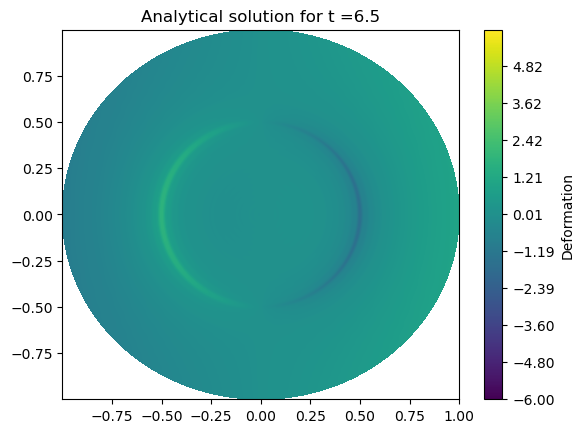

In [121]:
# plotting analytical solution

tstep = 650
Z_anali = Z_anal[:,:,tstep]

levels = np.linspace(-6,6,500)
# levels = np.linspace(np.min(Z_anali),np.max(Z_anali),200)

plt.figure()

plot = plt.contourf(X, Y, Z_anali, levels=levels, cmap='viridis')
# plot = plt.imshow(Z_anali)

colorbar = plt.colorbar(plot)
colorbar.set_label('Deformation')
plt.title("Analytical solution for t ="+ str(tstep/100));

In [125]:
# getting numerical solution DISCRETE NEXT STEP

# Z0 = Z_anal[:,:,0]               # set IC = numerical IC
# # Z0 = set_BC(np.zeros((N,N)), 0)  # set IC as it kind of should be

# dt_num = 1e-4
# total_time = dt_num

# Z1,Z0 = discrete_get_unp1(Z0,Z0, dt_num, dr_anal, dtheta_anal, total_time)

# Z_DNS = Z0


# Z_last = Z0
# Z = Z1
# num_timesteps = 10 * 1000
# # for i in tqdm(range(num_timesteps)):
# while total_time <= 0.13:
#     total_time = round(dt_num + total_time,5)
    
#     Znp1,Z = discrete_get_unp1(Z,Z_last, dt_num, dr_anal, dtheta_anal, total_time)

# #     Z_num = np.dstack((Z_num,Znp1))
    
#     Z_last = Z
#     Z = Znp1
    
# #     if (i+2) % 1000 == 0:
# #         Z_DNS = np.dstack((Z_DNS,Z))
        
#     if round(total_time,2) == total_time:
#         Z_DNS = np.dstack((Z_DNS,Z))

# print("Total simulation runtime: ",total_time)


def discrete_run(dt, max_time):
    Z0 = Z_anal[:,:,0]
    
    total_time = dt

    Z1,Z0 = discrete_get_unp1(Z0,Z0, dt, dr_anal, dtheta_anal, total_time)

    Z_DNS = Z0


    Z_last = Z0
    Z = Z1
    
    total_timesteps = int(max_time / dt)
    for i in tqdm(range(total_timesteps)):
        total_time = round(dt + total_time,9)

        Znp1,Z = discrete_get_unp1(Z,Z_last, dt, dr_anal, dtheta_anal, total_time)

        Z_last = Z
        Z = Znp1

        if round(total_time,2) == total_time:
#             print(total_time)
            Z_DNS = np.dstack((Z_DNS,Z))
            
    return Z_DNS

max_time = 6.5
# Z_DNS_1en1 = discrete_run(1e-1, max_time)
# Z_DNS_1en2 = discrete_run(1e-2, max_time)
# Z_DNS_1en3 = discrete_run(1e-3, max_time)
Z_DNS_1en4 = discrete_run(1e-4, max_time)
Z_DNS_1en5 = discrete_run(1e-5, max_time)
Z_DNS_1en6 = discrete_run(1e-6, max_time)

100%|██████████| 6500000/6500000 [16:04<00:00, 6736.77it/s] 


In [ ]:
Z_DNS_1en4_long = discrete_run(1e-4, 100)

 47%|████▋     | 467399/1000000 [17:40<38:58, 227.74it/s]

In [116]:
np.shape(Z_DNS_1en3)

(200, 200, 11)

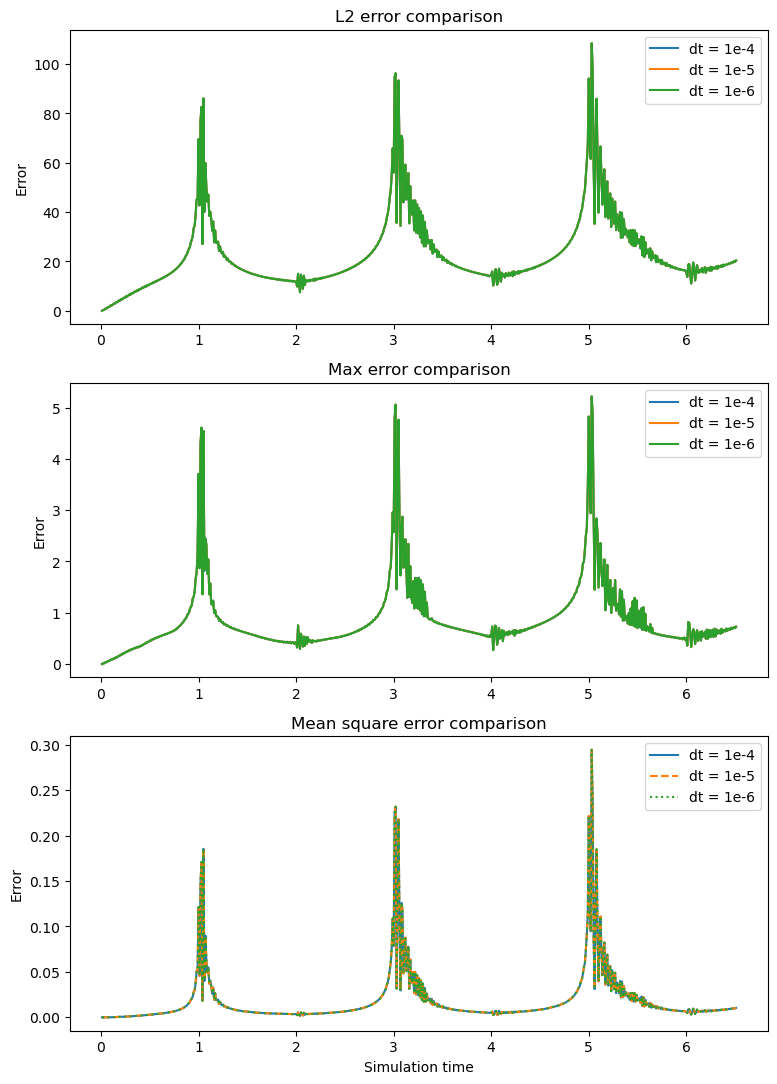

In [129]:
# error of numerical and analytical solutions

def get_errors(Z_DNS_dt):
    L2 = np.array(None)
    max_e = np.array(None)
    MSE = np.array(None)
    shape = np.shape(Z_DNS_dt)
    for i in list(range(shape[2])):
        Z_DNSi = Z_DNS_dt[:,:,i]
        Z_anali = Z_anal[:,:,i]
        L2i = np.sqrt(np.sum((Z_DNSi-Z_anali)**2))
        L2 = np.append(L2,L2i)
        max_e = np.append(max_e, np.max(np.abs(Z_DNSi-Z_anali)))
        MSE = np.append(MSE, np.sum((Z_DNSi-Z_anali)**2) / N**2)
        
    return L2, max_e, MSE

L2_1en6, max_e_1en6, MSE_1en6 = get_errors(Z_DNS_1en6)
L2_1en5, max_e_1en5, MSE_1en5 = get_errors(Z_DNS_1en5)
L2_1en4, max_e_1en4, MSE_1en4 = get_errors(Z_DNS_1en4)
# L2_1en3, max_e_1en3, MSE_1en3 = get_errors(Z_DNS_1en3)
# L2_1en2, max_e_1en2, MSE_1en2 = get_errors(Z_DNS_1en2)
# L2_1en1, max_e_1en1, MSE_1en1 = get_errors(Z_DNS_1en1)

simulation_time = np.linspace(0, len(L2_1en4)-1, len(L2_1en4)) / 100


fig = plt.figure()
fig.set_figheight(13)
fig.set_figwidth(9)


plt.subplot(3,1,1)
plt.plot(simulation_time, L2_1en4)
plt.plot(simulation_time, L2_1en5)
plt.plot(simulation_time, L2_1en6)
# plt.plot(simulation_time, L2_1en3)
# plt.plot(L2_1en2)
# plt.plot(L2_1en1)
plt.legend(["dt = 1e-4","dt = 1e-5", "dt = 1e-6"])
plt.ylabel("Error")
plt.title("L2 error comparison")

plt.subplot(3,1,2)
plt.plot(simulation_time, max_e_1en4)
plt.plot(simulation_time, max_e_1en5)
plt.plot(simulation_time, max_e_1en6)
# plt.plot(simulation_time, max_e_1en3)
# plt.plot(max_e_1en2)
# plt.plot(max_e_1en1)
plt.legend(["dt = 1e-4","dt = 1e-5", "dt = 1e-6"])
plt.ylabel("Error")
plt.title("Max error comparison")

plt.subplot(3,1,3)
plt.plot(simulation_time, MSE_1en4)
plt.plot(simulation_time, MSE_1en5,'--')
plt.plot(simulation_time, MSE_1en6,':')
# plt.plot(simulation_time, MSE_1en3)
# plt.plot(MSE_1en2)
# plt.plot(MSE_1en1)
plt.legend(["dt = 1e-4","dt = 1e-5", "dt = 1e-6"])
plt.xlabel("Simulation time")
plt.ylabel("Error")
plt.title("Mean square error comparison");

# plt.savefig("error_comparison.png")

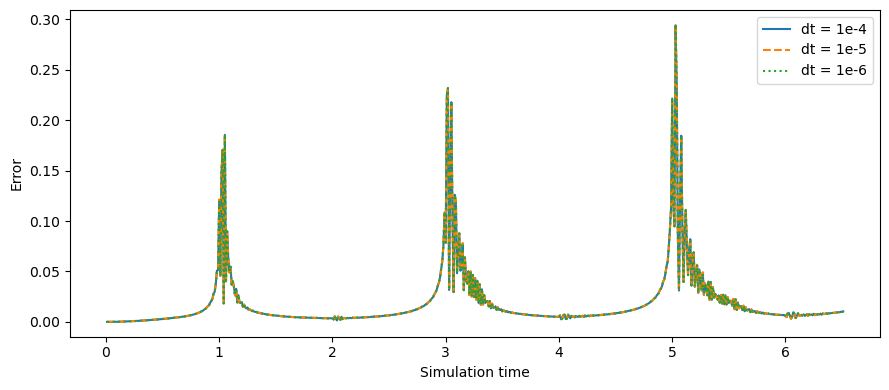

In [133]:
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(9)

plt.plot(simulation_time, MSE_1en4)
plt.plot(simulation_time, MSE_1en5,'--')
plt.plot(simulation_time, MSE_1en6,':')
# plt.plot(simulation_time, MSE_1en3)
# plt.plot(MSE_1en2)
# plt.plot(MSE_1en1)
plt.legend(["dt = 1e-4","dt = 1e-5", "dt = 1e-6"])
plt.xlabel("Simulation time")
plt.ylabel("Error")
# plt.title("Mean square error comparison");
plt.tight_layout()
plt.savefig("error_comparison.png")

there are 101 total timesteps


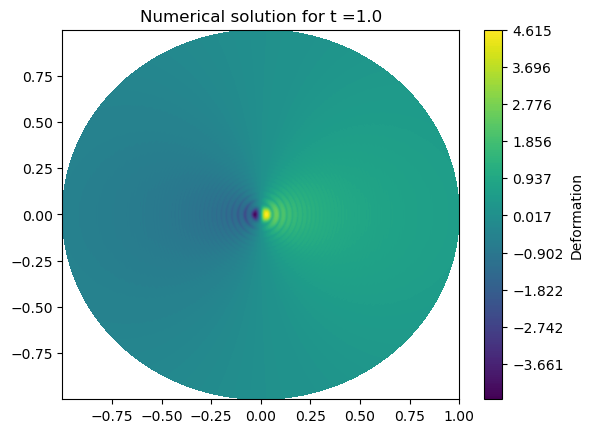

In [97]:
# test plot of numerical solution
shape = np.shape(Z_num)
print("there are " + str(shape[2]) + " total timesteps")

tstep = 100
Z_numi = Z_num[:,:,tstep]
# Z_numi = set_BC(Z_numi,0,None)

levels = np.linspace(-6,6,500)
levels = np.linspace(np.min(Z_numi),np.max(Z_numi),200)

plt.figure()

plot = plt.contourf(X, Y, Z_numi, levels=levels, cmap='viridis')
# plot = plt.imshow(Z_numi)

colorbar = plt.colorbar(plot)
colorbar.set_label('Deformation')
plt.title("Numerical solution for t ="+ str(tstep/100));

In [54]:
np.shape(Z_DNS_1en1)

(200, 200, 2)

In [53]:
# plotting numerical solution from after a long run when only t increments of 0.01 are saved

tstep = 2
Z_DNSi = Z_DNS_1en1[:,:,tstep]

levels = np.linspace(-6,6,500)
# levels = np.linspace(np.min(Z_numi),np.max(Z_DNSi),15)

plt.figure()
contour = plt.contourf(X, Y, Z_DNSi, levels=levels, cmap='viridis')
colorbar = plt.colorbar(contour)
colorbar.set_label('Deformation')
plt.title("Numerical solution for t ="+ str(tstep/100));

IndexError: index 2 is out of bounds for axis 2 with size 2

In [7]:
# getting numerical solution MATRIX

Z0 = Z_anal[:,:,0]               # set IC = numerical IC
# Z0 = set_BC(np.zeros((N,N)), 0)  # set IC as it kind of should be
Z_num = Z0

dt_num = 1e-5
total_time = dt_num

Z0_flat = flatten(Z0)

Z1_flat = np.matmul(A_RHS_inv,Z0_flat)


Z_last_flat = Z1_flat
num_timesteps = int(0.01 * 1e5)
for i in tqdm(range(num_timesteps)):
    total_time = round(dt_num + total_time,5)
    
    Z_next_flat = np.matmul(A_RHS_inv,Z_last_flat) - Z_last_flat
#     Z_next_flat = A_sparse_inv@Z_last_flat - Z_last_flat
    
    Z_next = set_BC(unflatten(Z_next_flat),total_time)
    
    Z_last_flat = flatten(Z_next)
    
    Z_num = np.dstack((Z_num,Z_next))

#     if total_time % 0.01 == 0:
#         Z_num = np.dstack((Z_num,Z_next))
#         np.save("./Z_iterative.npy",Z_num)


KeyboardInterrupt



In [152]:
# calculate A data

t0 = time.time()
A = get_A(1e-5,dr_anal,dtheta_anal)
t1 = time.time()
print("Got A in",round(t1-t0,2),"seconds")
A_sparse = csc_matrix(A)
t2 = time.time()
A_sparse_inv = sp.sparse.linalg.inv(A_sparse) # ~10 mins
t3 = time.time()
print("Inverted A_sparse in",round(t3-t2),"seconds")
A_inv = A_sparse_inv.toarray()
t4 = time.time()
print("Total cell runtime",round(t4-t0),"seconds")

In [104]:
# calculate A_RHS data

t0 = time.time()

A_RHS = get_A_RHS(1e-5,dr_anal,dtheta_anal)
t1 = time.time()
print("Got A_RHS in",round(t1-t0,2),"seconds")

A_RHS_sparse = csc_matrix(A_RHS)
t2 = time.time()

A_RHS_sparse_inv = sp.sparse.linalg.inv(A_RHS_sparse) # ~10 mins
t3 = time.time()
print("Inverted A_RHS_sparse in",round(t3-t2),"seconds")

A_RHS_inv = A_RHS_sparse_inv.A
t4 = time.time()
print("Total cell runtime",round(t4-t0),"seconds")

Got A_RHS in 0.51 seconds

Intel MKL ERROR: Parameter 2 was incorrect on entry to DGEMV .

Intel MKL ERROR: Parameter 2 was incorrect on entry to DGEMV .

Intel MKL ERROR: Parameter 2 was incorrect on entry to DGEMV .

Intel MKL ERROR: Parameter 2 was incorrect on entry to DGEMV .

Intel MKL ERROR: Parameter 2 was incorrect on entry to DGEMV .

Intel MKL ERROR: Parameter 2 was incorrect on entry to DGEMV .

Intel MKL ERROR: Parameter 2 was incorrect on entry to DGEMV .

Intel MKL ERROR: Parameter 2 was incorrect on entry to DGEMV .

Intel MKL ERROR: Parameter 2 was incorrect on entry to DGEMV .

Intel MKL ERROR: Parameter 2 was incorrect on entry to DGEMV .

Intel MKL ERROR: Parameter 2 was incorrect on entry to DGEMV .

Intel MKL ERROR: Parameter 2 was incorrect on entry to DGEMV .

Intel MKL ERROR: Parameter 2 was incorrect on entry to DGEMV .

Intel MKL ERROR: Parameter 2 was incorrect on entry to DGEMV .


RuntimeError: failed to factorize matrix at line 413 in file ../scipy/sparse/linalg/_dsolve/SuperLU/SRC/dpanel_bmod.c
